# <span style="color:purple"> Week 7 - Information Extraction
### <span style="color:purple">Reuters Newspaper</span>  
<span style="color:purple">-- File: Jingying (Jane) Bi Homework 7 <br>
-- Name: Jingying Bi <br>
-- UCID: 12174556 <br>
<br>
    
<span style="color:purple">**Research Object: ** <br>
Compare the Reuters news from three classes, economy, environment, entertainment -- how they respond to the 2007~2008 financial crisis. 

<span style="color:purple">**Method: ** <br>
(1)  POS tagging <br>
(2)  NER tagging <br>
(3)  Parsing Tree and Dependency parse <br>
       
<span style="color:purple">**Dataset:** <br>
<span style="color:purple"> In this assignment, I use 2017 Reuters News from Oct ~ Dec 2008. Each news on Reuters has a tag marked by the website. I utilize these tags to create three classes. Class *Economy* includes tags "private equity", "global market", and "company". Class *Entertainment* includes tags "art", "film", and "entertainment". Class *Environment* includes tag "environment". 2017 Reuters news have been divided into 1468 *Economy* news, 348 *Entertainment* news and 201 *Environment* news. <br>
In my analysis below, I take out 10 news from each of class. <br>
    

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk
from nltk.corpus import stopwords #For stopwords

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

# to build tables
import sys
from astropy.table import Table

# to calculate precisions F-measure
import sklearn

%matplotlib inline

In [3]:
lucem_illud.setupStanfordNLP()
import lucem_illud.stanford as stanford

Starting downloads, this will take 5-10 minutes
../stanford-NLP/parser already exists, skipping download
../stanford-NLP/ner already exists, skipping download
../stanford-NLP/postagger already exists, skipping download
../stanford-NLP/core already exists, skipping download
[100%]Done setting up the Stanford NLP collection


/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

## <span style="color:purple"> 1.1 Load Corpus

In [4]:
# load data
ReutersDF = pandas.read_csv('Reuters_2017News.csv')
ReutersDF[:3]

,Unnamed: 0,Year,Month,Day,Title,Topic,News,Link
0,0,2008,12,1,"Earthquake rattles Taiwan, no reports of damage",environment,Reuters Staff1 Min ReadTAIPEI (Reuters) - An e...,http://www.reuters.com/article/environmentNews...
1,1,2008,12,1,TREASURIES-Rise in Asia after Bernanke talks o...,economy,Reuters Staff3 Min Read * Treasuries edge up i...,http://www.reuters.com/article/companyNewsAndP...
2,2,2008,12,1,GLOBAL MARKETS-Asia stocks slide as global out...,economy,Reuters Staff4 Min Read * Asian shares fall 3-...,http://www.reuters.com/article/companyNewsAndP...


## <span style="color:purple"> 1.2 POS Tagging
<span style="color:purple">In this section, I select 10 sentences from each classes, namely enconomy, environment, and entertainment. <br>
Tokenize the sentences. <br>
Tokenize the words in each sentence. <br>
Tag Part of Speech on each word <br>

In [5]:
# grab 10 News in category "Economy", "Environment", "Entertainment"
Reuters_Economy = ReutersDF[ReutersDF['Topic']=='economy'][0:10]
Reuters_Environment = ReutersDF[ReutersDF['Topic']=='environment'][0:10]
Reuters_Entertainment = ReutersDF[ReutersDF['Topic']=='entertainment'][0:10]

# tokenize sentences then tokenize words in each tokenized sentence
#Reuters_Economy['tokenized_sentences'] = Reuters_Economy['News'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
Reuters_Economy['tokenized_sentences'] = Reuters_Economy['News'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
Reuters_Environment['tokenized_sentences'] = Reuters_Environment['News'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
Reuters_Entertainment['tokenized_sentences'] = Reuters_Entertainment['News'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

In [6]:
# POS tagging for each tokenized sentence
Reuters_Economy['POS_sents'] = Reuters_Economy['tokenized_sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))
Reuters_Environment['POS_sents'] = Reuters_Environment['tokenized_sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))
Reuters_Entertainment['POS_sents'] = Reuters_Entertainment['tokenized_sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

### <span style="color:purple"> 1.2.1 POS Counting Funtion: *POS_Counting( )*
<span style="color:purple"> I hope to count the number of the frequency each word with its POS. <br>
Hence I create a function for repeated use.

In [7]:
# POS counting function
# input: corpus: the text to be analyzed
# input: countTarget: the POS that you want to count;
# input: top: number of top words tagged as countTarget
# output: the list of top number of top words tagged as countTarget
def POS_Counting(corpus, countTarget, top):
    targetCounts = {}
    for entry in corpus:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != countTarget:
                    continue
                elif ent in targetCounts:
                    targetCounts[ent] += 1
                else:
                    targetCounts[ent] = 1
    sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
    return sortedTargets[:20]

### <span style="color:purple"> 1.2.2 Make a Table for POS: *POS_Table( )*
<span style="color:purple"> **Methodology:**<br>
(1) I create a function to display the table which contains the top words of each POS (i.e. NN, VB, JJ) and the word frequencies. <br>
(2) I call this function three times to draw the tables for each class. 
    
<span style="color:purple"> **Findings:**<br>

<span style="color:purple">**For Economy Class:** <br>
Remeber that the background of these economy news is 2007~2008 Financial Crisis.<br>
In the NN column, the key words are "market", "government", "policy", "meeting", "company". These words depict the economic environment inhereted in these news -- market (is gloom), government (makes/ enacts) policy, (holds) meetings (to try to control the panic). company (is also highly envolved in the crisis) <br>
Interestingly, in the VB column, the verbs support my argument above. Specifically, I see "help", "hold", "protect", "revive", "alleviate", "allow". They depict that government tries to take a series actions to improve the situations. <br>

<span style="color:purple">**For Environment Class:** <br>
Most of words in the NN column are relevant to environemnt, which is within expectation. Such as "water", climate", "greenhouse", "gas", etc. These are the frequently discussed topics. 

<span style="color:purple">**For Entertainment Class:**<br>
In the NN column, "art", "film", "movie", "theater", "ceromony" are all the relevant words. <br>
However, from other columns of either Environment or Entertainment classes, it is a bit hard to capture the effect of the financial crisis. Though in the Entertainment--VB--column, there is "survive", "worry", "stir". It is unguaranteed that they are describing the impact of the crisis. To figure out what happens here, I need to retrieve which sentences contain these specific words.

In [8]:
# table function POS_Table
def POS_Table(count_list):
    # count the number of nouns 
    word_NN = []
    count_NN = []
    word_VB = []
    count_VB = []
    word_JJ = []
    count_JJ = []
    for i in range(0,20):
        word_NN.append(POS_Counting(count_list['POS_sents'], 'NN', 20)[i][0])
        count_NN.append(POS_Counting(count_list['POS_sents'], 'NN', 20)[i][1])
        word_VB.append(POS_Counting(count_list['POS_sents'], 'VB', 20)[i][0])
        count_VB.append(POS_Counting(count_list['POS_sents'], 'VB', 20)[i][1])
        word_JJ.append(POS_Counting(count_list['POS_sents'], 'JJ', 20)[i][0])
        count_JJ.append(POS_Counting(count_list['POS_sents'], 'JJ', 20)[i][1])
        t = Table([word_NN, count_NN,word_VB, count_VB,word_JJ, count_JJ], 
                  names=('NN', 'NN-count','VB','VB-count', 'JJ','JJ-count'))
    return t

### <span style="color:purple"> 1.2.3 Display Top POS for 3 Classes -- Economy, Environment, Entertainment

In [9]:
POS_Table(Reuters_Economy)

NN,NN-count,VB,VB-count,JJ,JJ-count
str10,int64,str9,int64,str14,int64
s,44,be,14,10-year,16
percent,42,buy,9,last,14
year,20,discuss,7,Japanese,10
market,19,“,7,new,9
government,15,help,7,previous,7
policy,11,hold,5,corporate,7
JGB,11,have,4,economic,6
“,11,yield,3,low,6
meeting,10,take,3,due,6


In [10]:
POS_Table(Reuters_Environment)

NN,NN-count,VB,VB-count,JJ,JJ-count
str10,int64,str7,int64,str13,int64
s,20,be,22,new,16
water,19,“,11,ambitious,9
climate,19,cut,9,global,7
city,15,have,6,environmental,7
government,13,succeed,4,economic,6
”,13,reduce,4,bottled,6
percent,12,agree,3,high,5
change,11,rise,3,first,4
greenhouse,10,help,3,other,4


In [11]:
POS_Table(Reuters_Entertainment)

NN,NN-count,VB,VB-count,JJ,JJ-count
str8,int64,str11,int64,str12,int64
s,27,be,19,other,8
“,26,“,10,contemporary,8
”,23,make,5,five-day,6
film,16,take,4,new,5
art,14,build,4,last,5
percent,12,See,3,next,4
movie,9,survive,3,many,4
year,9,review,3,three-day,4
industry,9,allow,3,prestigious,3


## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

## <span style="color:purple"> 2.1 NER Tagging

In [12]:
# NEr tagging for the tokenized sentences 
Reuters_Economy['NER_sents'] = Reuters_Economy['tokenized_sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))
Reuters_Environment['NER_sents'] = Reuters_Environment['tokenized_sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))
Reuters_Entertainment['NER_sents'] = Reuters_Entertainment['tokenized_sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

### <span style="color:purple"> 2.1.1 Most Common Entity Function: *most_common_entity( )*
<span style="color:purple"> To display the most common entities of the three classes here is a bit trivial because all the listed words do not have critical meaings. <br>
In the Environment Entity, however, there appears a verb "said". This is interesting. Perhaps the Environment corpus writes a lot about discussions or someone's oppinions etc. <br>
This may be reasonable. Economy class, under the crisis, deals with macro issues or the companies' difficulties. Entertainment always talks about films, arts, where people having individual appreciation may tend to speak out less -- because appreciation is sufficient for self-happiness, "arguing" or "presenting" is less important. <br>
    In contrast, there are many disagreements and arguments over the environment issues. People or countries tend to raise their stands and speak out. This may drive "said" on the list of most common entity.

In [13]:
# find the most common entities (boring results)
def most_common_entity(ner_tagged_text):
    entityCounts = {}
    for entry in ner_tagged_text:
        for sentence in entry:
            for ent, kind in sentence:
                if ent in entityCounts:
                    entityCounts[ent] += 1
                else:
                    entityCounts[ent] = 1
    sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
    return sortedEntities[:10]

### <span style="color:purple"> 2.1.2 Display Top Entities for 3 Classes -- Economy, Environment, Entertainment


In [14]:
econ_entity = []
econ_count = []
envi_entity = []
envi_count = []
enter_entity = []
enter_count = []
for i in range(0,10):
    econ_entity.append(most_common_entity(Reuters_Economy['NER_sents'])[i][0])
    econ_count.append(most_common_entity(Reuters_Economy['NER_sents'])[i][1])
    envi_entity.append(most_common_entity(Reuters_Environment['NER_sents'])[i][0])
    envi_count.append(most_common_entity(Reuters_Environment['NER_sents'])[i][1])
    enter_entity.append(most_common_entity(Reuters_Entertainment['NER_sents'])[i][0])
    enter_count.append(most_common_entity(Reuters_Entertainment['NER_sents'])[i][1])

CommonEntity_Table = Table([econ_entity, econ_count, envi_entity, envi_count, enter_entity, enter_count],
                  names=('Econ Entity', 'Econ Count','Environmnet Entity','Environmnet Count', 'Entertain Entity','Entertain Count'))
CommonEntity_Table

Econ Entity,Econ Count,Environmnet Entity,Environmnet Count,Entertain Entity,Entertain Count
str3,int64,str4,int64,str3,int64
",",209,",",192,",",237
the,174,the,189,the,181
.,141,.,159,.,151
to,130,to,122,and,131
a,106,of,112,a,119
in,90,and,95,to,108
of,82,in,84,of,95
and,64,a,77,in,87
’,55,said,57,“,86


### <span style="color:purple"> 2.1.3 NER Counting Funtion: *NER_Count( )*

In [15]:
# function to show the top non-objets, orgnizations etc.
# input: ner_tagged_text -- the ner tagged text
# input: entity_type, including NON-OBJECT, ORGANIZATION, LOCATION, PERSON
# top: length of the result list
def NER_count(ner_tagged_text, entity_type, top):
    Counts = {}
    if entity_type == 'NON-OBJECT':
        for entry in ner_tagged_text:
            for sentence in entry:
                for ent, kind in sentence:
                    if kind == 'O':
                        continue
                    elif ent in Counts:
                        Counts[ent] += 1
                    else:
                        Counts[ent] = 1
        sorted_entity = sorted(Counts.items(), key = lambda x: x[1], reverse = True) 
    else:     
        for entry in ner_tagged_text:
            for sentence in entry:
                for ent, kind in sentence:
                    if kind != entity_type:
                        continue
                    elif ent in Counts:
                        Counts[ent] += 1
                    else:
                        Counts[ent] = 1
        sorted_entity = sorted(Counts.items(), key = lambda x: x[1], reverse = True)
    return sorted_entity[:10]

### <span style="color:purple"> 2.1.4 Make a Table for NER: *NER_Table( )*

In [16]:
# table function NER_Table
def NER_Table(count_list):
    # count the number of nouns 
    word_non_obj = []
    count_non_obj = []
    word_org = []
    count_org = []
    word_person = []
    count_person = []
    word_loc = []
    count_loc = []
    for i in range(0,10):
        word_non_obj.append(NER_count(count_list, 'NON-OBJECT',10)[i][0])       
        count_non_obj.append(NER_count(count_list, 'NON-OBJECT',10)[i][1])       
        word_org.append(NER_count(count_list, 'ORGANIZATION',10)[i][0])       
        count_org.append(NER_count(count_list, 'ORGANIZATION',10)[i][1])       
        word_person.append(NER_count(count_list, 'PERSON',10)[i][0])       
        count_person.append(NER_count(count_list, 'PERSON',10)[i][1])       
        word_loc.append(NER_count(count_list, 'LOCATION',10)[i][0])       
        count_loc.append(NER_count(count_list, 'LOCATION',10)[i][1])       
        
        #t = Table([word_NN, count_NN,word_VB, count_VB,word_JJ, count_JJ], 
        #          names=('NN', 'NN-count','VB','VB-count', 'JJ','JJ-count'))
        
        t = Table([word_non_obj, count_non_obj, word_org, count_org, word_person, count_person,word_loc, count_loc],
                  names=('Non-Objective', 'Non-Obj-count','Organization','Org-count', 'Person','Per-count', 'Location', 'Loc-count')) 
    return t

### <span style="color:purple"> 2.1.5 Display Top NER for 3 Classes -- Economy, Environment, Entertainment
<span style="color:purple"> **Methodology:** <br>
(1) Call the function to count the top entities of NON-OBJECT, ORGANIZATION, PERSON, LOCATION<br>
(2) Call the table function for display
    
<span style="color:purple"> **Findings:** <br>
    
<span style="color:purple">**In Economy Class:** <br>
<span style="color:purple">I see "Fed", "Bernanke", "Treasury", "Securities", "Bank". These reflect that the most discussed topics in these 10 news articles are how Fed, Treasury response to the financial crisis. Ben Bernanke is the Fed chair in 2006~2014. Hence it is reasonable to see his name, and to see his name together with Fed. <br>  
Moreover, "Tokyo", "U.S.", "HK", "Seoul" appear many times. This may be merely due to that the 10 news articles are most about Asia cities and U.S. But "Venezuela" tends to significantly signal the crisis due to its collapse during the crisis. <br>

<span style="color:purple">**In Environment Classes: ** <br>
<span style="color:purple">It is rather interesting to see politicians appear on the lists. <br>
In Environment, I see "Obama" (Democratic), "Bush" (Republic). Their presidency are before, during and after the crisis. So it is reasonable to see their names. <br>
Some countries "Brazil", "Poland", "Canada", "EU". They appear here could be due to they are the very active countries/cities/union in environment issues. Or these countries are also troubled in the crisis. The impact of the crisis expand into the Environment sector. <br>

<span style="color:purple">**In Entertainment Classes: ** <br>
<span style="color:purple">In contrast, in the Entertainment class, I see "Trump" (Republican), "Nixon" (Republican), "Mumbai", "India". <br>
First, it is interesting to see "Trump" and "Nixon". Both are Republican, neither of them are in their presidency. And they appear on the list of Entertainment!!! To figure out what happens, I should start from retrieving the text containing their names. <br>
"India" "Mumbai" are highly mentioned, which is slightly beyond expectation. This may indicate some culture shocks, or the impact of foreign cultures on U.S. While if the 10 news articles are most based on India/ Mumbai, then it is natural to see their names on the top of the list. So need to trace back to the original content before drawing any conclusion. <br>


In [17]:
# NER table for economics
print('-------------------------- NER table for economics --------------------------')
NER_Table(Reuters_Economy['NER_sents'])

-------------------------- NER table for economics --------------------------


Non-Objective,Non-Obj-count,Organization,Org-count,Person,Per-count,Location,Loc-count
str10,int64,str10,int64,str9,int64,str9,int64
U.S.,22,Reuters,20,Chavez,15,U.S.,20
Reuters,20,BOJ,16,Bernanke,7,Venezuela,6
BOJ,16,of,9,Ebihara,5,TOKYO,5
Chavez,15,Fed,7,),4,Japan,5
of,9,Treasury,6,Ben,2,Asia,3
Japan,9,Securities,6,Takahashi,2,Tokyo,3
Fed,7,Dec,5,Masayuki,2,HONG,2
Bernanke,7,Bank,5,Kitano,2,KONG,2
Treasury,6,JGB,5,Shinji,2,Seoul,2


In [18]:
print('-------------------------- NER table for environment --------------------------')
NER_Table(Reuters_Environment['NER_sents'])

-------------------------- NER table for environment --------------------------


Non-Objective,Non-Obj-count,Organization,Org-count,Person,Per-count,Location,Loc-count
str7,int64,str9,int64,str7,int64,str9,int64
Reuters,19,Reuters,19,Obama,12,Brazil,14
U.S.,14,EU,7,Bush,8,U.S.,13
Brazil,14,U.N.,5,Watson,5,Poland,11
Obama,12,Climate,5,Boer,4,Canada,7
Poland,11,European,4,Yvo,3,Poznan,6
Canada,10,CCS,4,de,3,Venice,6
Bush,8,Committee,3,Wilkins,3,Britain,5
EU,7,of,3,Turner,3,Europe,4
Poznan,6,Min,3,Barack,2,Taiwan,3


In [19]:
print('-------------------------- NER table for entertainment --------------------------')
NER_Table(Reuters_Entertainment['NER_sents'])

-------------------------- NER table for entertainment --------------------------


Non-Objective,Non-Obj-count,Organization,Org-count,Person,Per-count,Location,Loc-count
str7,int64,str9,int64,str6,int64,str10,int64
Reuters,13,Reuters,13,Leckey,12,U.S.,10
Leckey,12,GM,5,Paul,8,Mumbai,7
U.S.,11,Corp,4,Trump,8,India,6
Paul,8,Congress,4,Nixon,7,London,4
Trump,8,Ford,4,Mark,5,Britain,4
Mumbai,7,Chrysler,4,Frost,5,Detroit,4
Nixon,7,Turner,3,Wilkes,4,Washington,4
New,6,General,3,Serota,4,New,4
India,6,Committee,3,Smith,4,United,4


## <span style="color:purple"> 2.2 Evaluate NER -- an example of Reuters Entertainment News
### <span style="color:purple"> 2.2.1 Hand-coding the ground truth
<span style="color:purple">Example is from 2008.12.01 news "BOJ offers dollars at fixed rate of 1.420 pct".
The text is: <br>
<span style="color:purple">*Reuters Staff1 Min Read TOKYO, Dec 2 (Reuters) - The Bank of Japan said on Tuesday it has offered an unlimited amount of three-month dollar funds at a fixed rate of 1.420 percent, as part of worldwide central bank efforts to deal with dollar shortages.   The BOJ said the start date for the operation was Dec. 4 in the United States and the end date was Feb. 26 in the United States.*
    
<span style="color:purple"> **Methodology:** <br>
(1) Tokenize sentences <br>
    (2) Tokenize words in each sentence <br>
    (3) hand-coding the entity of each word <br>
    (4) obtain the NER taggings <br>
    (5) Evaluate the NER tagging by calculating precision, recall, F-measure. <br>
    
<span style="color:purple"> **Result:** <br>
    Three metrics tell that the NER tagging performs well. Notice: the performance should be dependent on the length and complexity. Moreover, some words have multiple entity candidate, which could lead to the wrong tagging also.

In [20]:
news = ReutersDF['News'][5]
news

'Reuters Staff1 Min Read TOKYO, Dec 2 (Reuters) - The Bank of Japan said on Tuesday it has offered an unlimited amount of three-month dollar funds at a fixed rate of 1.420 percent, as part of worldwide central bank efforts to deal with dollar shortages.   The BOJ said the start date for the operation was Dec. 4 in the United States and the end date was Feb. 26 in the United States.  '

In [21]:
# tokenize
news_token_sent = nltk.sent_tokenize(news)
news_token_word = [nltk.word_tokenize(s) for s in news_token_sent]

In [22]:
# list the hand coding entity
word = []
hand_coding_entity = []
num_sent = len(news_token_sent)
for s in range(0,num_sent):
    # look for number of words in each sentence
    num_word = len(news_token_word[s])
    for w in range(0,num_word):
        word.append(news_token_word[s][w])
word
hand_coding_entity = ['ORGANIZATION', 'PERSON','O','O','LOCATION','O',
               'O','O','O','ORGANIZATION','O',
               'O','O','ORGANIZATION','O','LOCATION',
               'O','O','O','O','O',
               'O','O','O','O','O',
               'O','O','O','O','O',
               'O','O','O','O','O',
               'O','O','O','O','LOCATION',
               'LOCATION','ORGANIZATION','O','O','O',
               'O','O','O','O','O',
               'ORGANIZATION','O','O','O','O',
               'O','O','O','O','O',
               'O','O','O','O','LOCATION',
               'O','O','O','O','O',
               'O','O','O','O','O',
               'O','O']

In [23]:
# List the NER tagging
NER_text = stanford.nerTagger.tag_sents(news_token_word)
NER_entity = []
for s in range(0,len(NER_text)):
    for w in range(0,len(NER_text[s])):
        NER_entity.append(NER_text[s][w][1])
NER_entity

['ORGANIZATION',
 'O',
 'O',
 'O',
 'LOCATION',
 'O',
 'O',
 'O',
 'O',
 'ORGANIZATION',
 'O',
 'O',
 'O',
 'ORGANIZATION',
 'ORGANIZATION',
 'ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'LOCATION',
 'LOCATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'LOCATION',
 'LOCATION',
 'O']

### <span style="color:purple"> 2.2.2 Evaluation

In [24]:
# Let's calculate the precision, recall, and F-measures.
print('The precision is ', sklearn.metrics.precision_score(NER_entity, hand_coding_entity, average = 'weighted')) #precision
print('The recall is ', sklearn.metrics.recall_score(NER_entity, hand_coding_entity, average = 'weighted')) #recall
print('The F-measure is ', sklearn.metrics.f1_score(NER_entity, hand_coding_entity, average = 'weighted')) #F-1 measure

The precision is  0.8948717948717948
The recall is  0.8846153846153846
The F-measure is  0.8892773892773892


/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

## <span style="color:purple"> 3.1 Parse
<span style="color:purple"> I will continue to use the 2008.12.01 news *"BOJ offers dollars at fixed rate of 1.420 pct"*. <br >
<span style="color:purple"> The text is: <br>
Reuters Staff1 Min Read TOKYO, Dec 2 (Reuters) - The Bank of Japan said on Tuesday it has offered an unlimited amount of three-month dollar funds at a fixed rate of 1.420 percent, as part of worldwide central bank efforts to deal with dollar shortages. The BOJ said the start date for the operation was Dec. 4 in the United States and the end date was Feb. 26 in the United States.

In [25]:
parses = list(stanford.parser.parse_sents(news_token_word)) #Converting the iterator to a list so we can call by index. They are still 
SentParseTree_1 = list(parses[0])
SentParseTree_2 = list(parses[1]) #iterators so be careful about re-running code, without re-running this block

In [26]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [27]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [28]:
treeRelation(SentParseTree_1, 'NP', 'Bank', 'Japan')

[[('NP', 'Reuters Staff1 Min Read TOKYO , Dec 2 Reuters - The Bank of Japan')],
 [('NP', 'Dec 2 Reuters - The Bank of Japan')],
 [('NP', 'The Bank of Japan')]]

In [29]:
treeRelation(SentParseTree_2, 'NP', 'United', 'States')

[[('NP', 'Dec. 4 in the United States')],
 [('NP', 'the United States')],
 [('NP', 'Feb. 26 in the United States')],
 [('NP', 'the United States')]]

In [30]:
SentParseTree_1[0].pretty_print()

                                                                                                                                                       ROOT                                                                                                                                                                      
                                                                                                                                                        |                                                                                                                                                                         
                                                                                                                                                        S                                                                                                                                                                        
                                 

In [31]:
SentParseTree_2[0].pretty_print()

                                                                           ROOT                                                                                  
                                                                            |                                                                                     
                                                                            S                                                                                    
      ______________________________________________________________________|__________________________________________________________________________________   
     |                                          VP                                                                                                             | 
     |        __________________________________|_____________________________________                                                                         |  
     |       |           

In [32]:
depParses = list(stanford.depParser.raw_parse_sents(news_token_sent)) #Converting the iterator to a list so we can call by index. They are still 
SentDepParseTree_1 = list(depParses[0])[0] 
SentDepParseTree_2 = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block


In [33]:
def DepPath_graph(SentDepParse):
    try:
        SentGraph = graphviz.Source(SentDepParse.to_dot())
    except:
        SentGraph = None
        print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
    return SentGraph

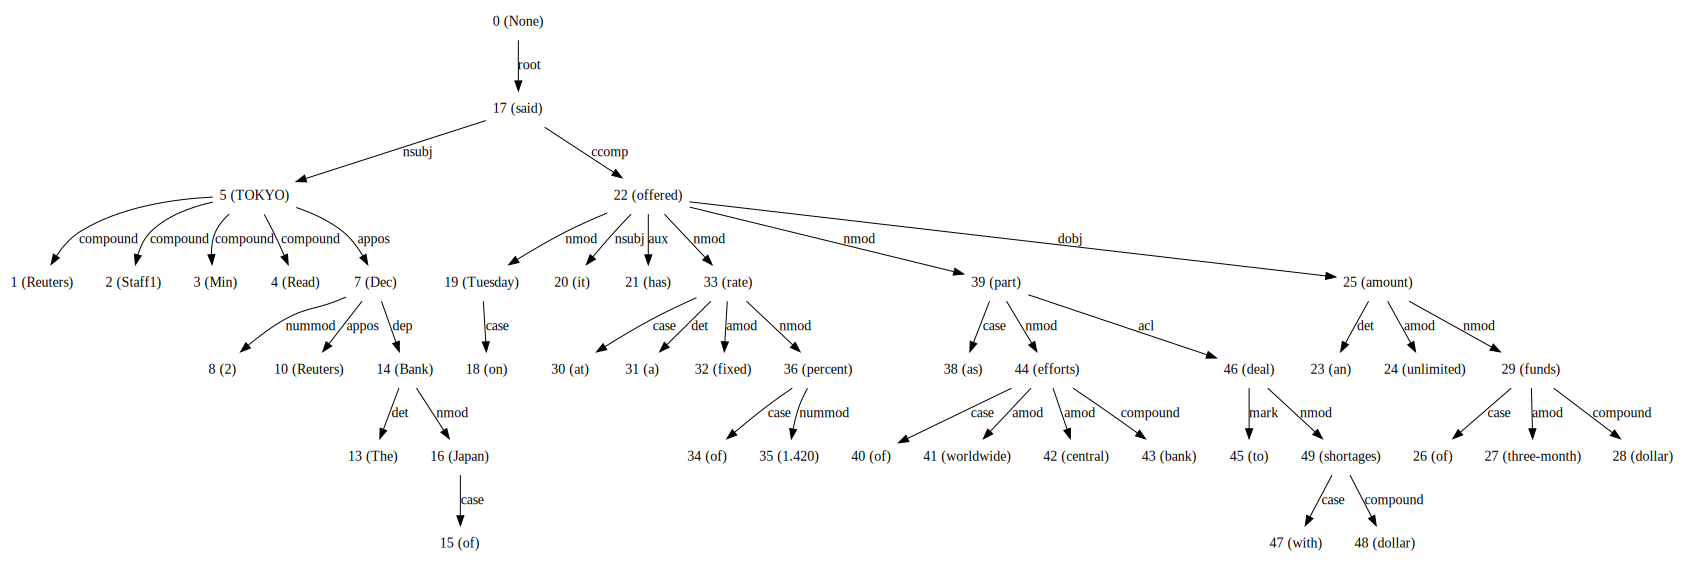

In [34]:
DepPath_graph(SentDepParseTree_1)

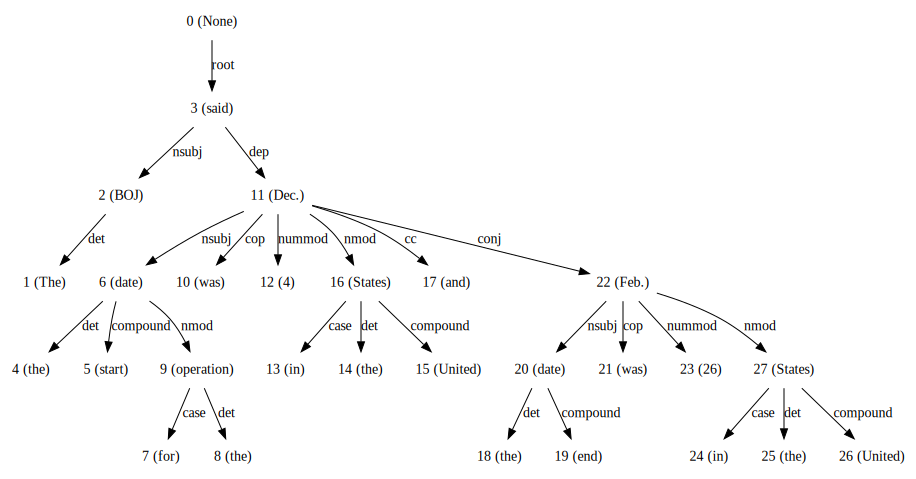

In [35]:
DepPath_graph(SentDepParseTree_2)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

In [ ]:
ieDF = stanford.openIE(news_token_sent)

Starting OpenIE run


In [ ]:
ieDF

<span style="color:purple"> Unable to run the code above. Always clash -- "the file died" warnings. Hence I cannot see the results to analyze. <br>
Most important and interesting analysis have been down in the previous sections :-)

<span style="color:purple"><span style="color:purple">*----------------END----------------* <br>
<span style="color:purple">February 21st, 2018 at Regenstein Library <br>
<span style="color:purple">Jingying Bi <br>